<a href="https://colab.research.google.com/github/azzindani/02_Data_Science/blob/main/Cifar_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 00 Importing Modules

In [ ]:
import pathlib
import os
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import random
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import datasets, layers, models, losses, initializers, Model, regularizers, activations, backend, Sequential

## 01 Importing & Extracting Files

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

--2024-02-16 01:41:28--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.2’

cifar-100-python.ta 100%[===================>] 161.17M  49.7MB/s    in 3.6s    

2024-02-16 01:41:31 (44.8 MB/s) - ‘cifar-100-python.tar.gz.2’ saved [169001437/169001437]



In [ ]:
!tar -xzvf "/content/cifar-100-python.tar.gz"

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
def unpickle(file_dir):
  with open(file_dir, 'rb') as fo:
      dict = pickle.load(fo, encoding = 'bytes')
  return dict

In [ ]:
data_dir = '/content/cifar-100-python'

train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
meta_dir = data_dir + '/meta'

## 02 Data & Class Preparation

In [ ]:
train_dict = unpickle(train_dir)
test_dict = unpickle(test_dir)
meta_dict = unpickle(meta_dir)

In [ ]:
superclass_df = pd.DataFrame(meta_dict[b'coarse_label_names'], columns = ['super_class'])
superclass_df  = superclass_df.stack().str.decode('utf-8').unstack()
superclass_df.head(2)

,super_class
0,aquatic_mammals
1,fish


In [ ]:
superclass_dict = {}

for i, row in superclass_df.iterrows():
  superclass_dict[i] = row[0]

In [ ]:
superclass_dict[10]

'large_natural_outdoor_scenes'

In [ ]:
class_df = pd.DataFrame(meta_dict[b'fine_label_names'], columns = ['class'])
class_df  = class_df.stack().str.decode('utf-8').unstack()
class_df.head(2)

,class
0,apple
1,aquarium_fish


In [ ]:
class_dict = {}

for i, row in class_df.iterrows():
  class_dict[i] = row[0]

In [ ]:
class_dict[30]

'dolphin'

In [ ]:
train_data = train_dict[b'data']
train_data = train_data / 255.
train_data = np.array(train_data)
train_data = train_data.reshape(len(train_data), 3, 32, 32).transpose(0, 2, 3, 1)

train_label = train_dict[b'fine_labels']
train_label = np.array(train_label)

x_test = test_dict[b'data']
x_test = x_test / 255.
x_test = np.array(x_test)
x_test = x_test.reshape(len(x_test), 3, 32, 32).transpose(0, 2, 3, 1)

y_test = test_dict[b'fine_labels']
y_test = np.array(y_test)

In [ ]:
print('train_data :', train_data.shape)
print('train_label :', train_label.shape)
print('x_test :', x_test.shape)
print('y_test :', y_test.shape)

train_data : (50000, 32, 32, 3)
train_label : (50000,)
x_test : (10000, 32, 32, 3)
y_test : (10000,)


## 03 Sample Check

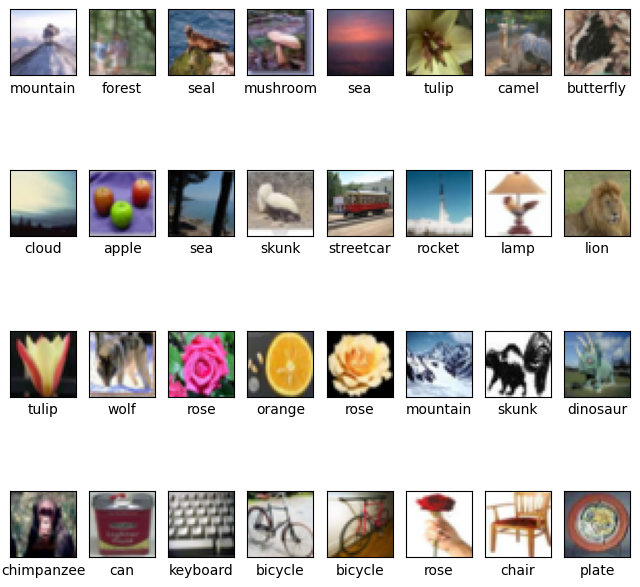

In [ ]:
n = 32
plt.figure(figsize = (8, 8))
for img in range(0, n):
  i = img
  plt.subplot(4, 8, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  j = i+0
  data_plot = x_test[j]
  plt.imshow(data_plot)
  plt.xlabel(str(class_dict[y_test[j]]))
plt.show()

## 04 Split Training, Validation, & Testing Data

In [ ]:
img_width = 32
img_height = 32

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_label, test_size = 0.2, random_state = 42)

print('x_train shape :', x_train.shape)
print('x_test shape :', x_test.shape)
print('x_val shape :', x_val.shape)

x_train shape : (40000, 32, 32, 3)
x_test shape : (10000, 32, 32, 3)
x_val shape : (10000, 32, 32, 3)


In [ ]:
y_classes = len(class_dict)
y_classes

100

## 05 Define Neural Network Model

In [ ]:
def conv_layer(inputs, filters, kernel = (1, 1), strides = 1):
  x = layers.BatchNormalization()(inputs)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters = filters, kernel_size = kernel, strides = strides, padding = 'same')(x)

  return x

In [ ]:
def dense_block(inputs, repetition, filters):
  for _ in range(repetition):
    y = conv_layer(inputs = inputs, filters = 4 * filters)
    y = conv_layer(inputs = y, filters = filters, kernel = (3, 3))
    x = layers.Concatenate(axis = 3)([y, inputs])

  return x

In [ ]:
def transition_layer(inputs):
  x = conv_layer(inputs = inputs, filters = (inputs.shape[-1] / 2))
  x = layers.AvgPool2D(pool_size = 2, strides = 2, padding = 'same')(inputs)

  return x

In [ ]:
inp = layers.Input(shape = (img_height, img_width, 3))

x = layers.experimental.preprocessing.Resizing(64, 64, interpolation = 'bilinear', input_shape = x_train.shape[1:])(inp)

x = layers.experimental.preprocessing.RandomFlip(mode = 'horizontal')(x)
x = layers.experimental.preprocessing.RandomRotation(factor = 0.1)(x)
x = layers.experimental.preprocessing.RandomZoom(height_factor = 0.1)(x)

x = layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 3, strides = 2, padding = 'same')(x)

for repetition in [6, 12, 24, 16]:
  d = dense_block(inputs = x, repetition = repetition, filters = 32)
  x = transition_layer(d)

x = layers.GlobalAveragePooling2D()(d)
x = layers.Dense(units = 512, activation = 'relu')(x)
x = layers.Dense(units = 128, activation = 'relu')(x)

x = layers.Dense(units = y_classes, activation = 'softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = x, name = 'Model_X')
model.summary()

Model: "Model_X"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 resizing (Resizing)         (None, 64, 64, 3)            0         ['input_1[0][0]']             
                                                                                                  
 random_flip (RandomFlip)    (None, 64, 64, 3)            0         ['resizing[0][0]']            
                                                                                                  
 random_rotation (RandomRot  (None, 64, 64, 3)            0         ['random_flip[0][0]']         
 ation)                                                                                     

## 06 Set Up Training

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
  def __init__(self, threshold):
    super(MyThresholdCallback, self).__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs['val_accuracy']
    acc = logs['accuracy']
    if val_acc >= self.threshold and acc >= self.threshold:
        self.model.stop_training = True

In [ ]:
es_callback = MyThresholdCallback(threshold = 0.97)

In [ ]:
model.compile(optimizer = 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

## 07 Model Training (Data Validation Included)

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(x_train, y_train, batch_size = 128, epochs = 100, validation_data = (x_val, y_val), callbacks = es_callback)

Epoch 1/100
313/313 [==============================] - 17s 26ms/step - loss: 3.9638 - accuracy: 0.0906 - val_loss: 4.5814 - val_accuracy: 0.0488
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 3.4809 - accuracy: 0.1607 - val_loss: 3.7830 - val_accuracy: 0.1263
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 3.1977 - accuracy: 0.2137 - val_loss: 3.5808 - val_accuracy: 0.1589
Epoch 4/100
313/313 [==============================] - 6s 21ms/step - loss: 3.0305 - accuracy: 0.2429 - val_loss: 3.3386 - val_accuracy: 0.1958
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 2.8778 - accuracy: 0.2742 - val_loss: 3.4593 - val_accuracy: 0.1818
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 2.7597 - accuracy: 0.2942 - val_loss: 3.1015 - val_accuracy: 0.2412
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 2.6722 - accuracy: 0.3128 - val_loss: 2.9536 - val_accuracy

## 08 Training Visualization

<Figure size 640x480 with 0 Axes>

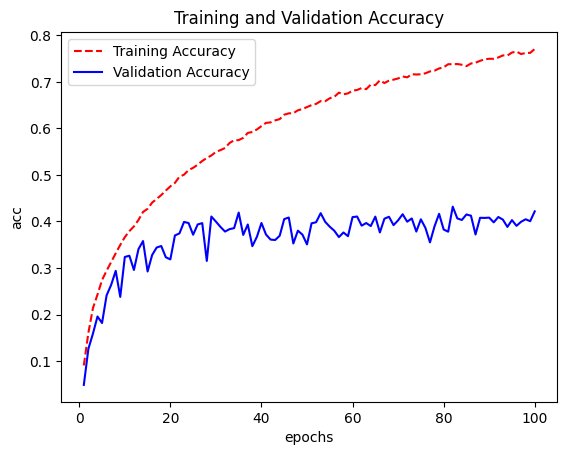

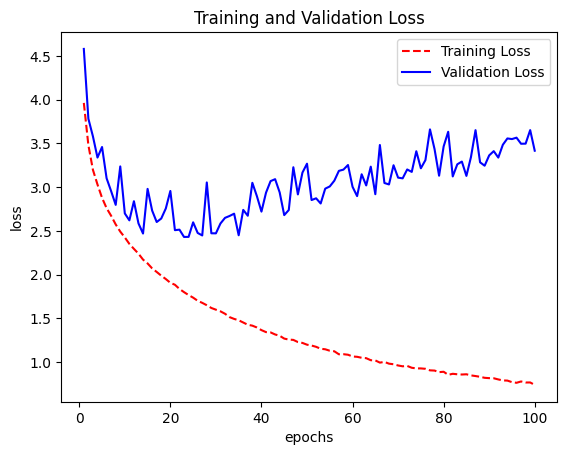

<Figure size 640x480 with 0 Axes>

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1, 1)

plt.plot(epochs, acc, 'r--', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r--', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()

## 09 Model Testing

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 3.4303 - accuracy: 0.4220


[3.4302613735198975, 0.421999990940094]

## 10 Checking The Result
### 10.01 Prediction Table

In [ ]:
test_label = []
predict_label = []
label_name =  []
predict_name = []
prediction_score = []

for i in range(0, x_test.shape[0]):
  test_label.append(y_test[i])
  t_label = class_dict[y_test[i]]
  label_name.append(t_label)

  img = x_test[i]
  img = tf.expand_dims(img, axis = 0)
  prediction = model.predict(img)
  dense = prediction.reshape(-1).tolist()
  score = max(dense)
  index = dense.index(score)
  predict_label.append(index)

  p_label = class_dict[index]
  predict_name.append(p_label)

  prediction_score.append(score)

prediction_result = pd.DataFrame({
  'label_num' : test_label,
  'label_name' : label_name,
  'predict_num' : predict_label,
  'predict_name' : predict_name,
  'predict_score' : prediction_score,
})

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


In [ ]:
prediction_result['pred_check'] = prediction_result['label_num'] == prediction_result['predict_num']
prediction_result.head()

,label_num,label_name,predict_num,predict_name,predict_score,pred_check
0,49,mountain,71,sea,0.402584,False
1,33,forest,42,leopard,0.714526,False
2,72,seal,37,house,0.202867,False
3,51,mushroom,91,trout,0.978261,False
4,71,sea,71,sea,0.810279,True


### 10.02 Confusion Matrix

In [ ]:
cm = confusion_matrix(prediction_result['label_name'], prediction_result['predict_name'])
n_class = cm.shape[0]

fig, ax = plt.subplots(figsize = (150, 150))
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax)

labels = class_df['class'].tolist()

ax.set(
  title = 'Confusion Matrix',
  xlabel = 'Predicted Label',
  ylabel = 'True label',
  xticks = np.arange(0.5, n_class + 0.5),
  yticks = np.arange(0.5, n_class + 0.5),
  xticklabels = labels,
)

ax.set_xticklabels(labels, ha = 'center', rotation = 90)
ax.set_yticklabels(labels, va = 'center', rotation = 0)

[Text(0, 0.5, 'apple'),
 Text(0, 1.5, 'aquarium_fish'),
 Text(0, 2.5, 'baby'),
 Text(0, 3.5, 'bear'),
 Text(0, 4.5, 'beaver'),
 Text(0, 5.5, 'bed'),
 Text(0, 6.5, 'bee'),
 Text(0, 7.5, 'beetle'),
 Text(0, 8.5, 'bicycle'),
 Text(0, 9.5, 'bottle'),
 Text(0, 10.5, 'bowl'),
 Text(0, 11.5, 'boy'),
 Text(0, 12.5, 'bridge'),
 Text(0, 13.5, 'bus'),
 Text(0, 14.5, 'butterfly'),
 Text(0, 15.5, 'camel'),
 Text(0, 16.5, 'can'),
 Text(0, 17.5, 'castle'),
 Text(0, 18.5, 'caterpillar'),
 Text(0, 19.5, 'cattle'),
 Text(0, 20.5, 'chair'),
 Text(0, 21.5, 'chimpanzee'),
 Text(0, 22.5, 'clock'),
 Text(0, 23.5, 'cloud'),
 Text(0, 24.5, 'cockroach'),
 Text(0, 25.5, 'couch'),
 Text(0, 26.5, 'crab'),
 Text(0, 27.5, 'crocodile'),
 Text(0, 28.5, 'cup'),
 Text(0, 29.5, 'dinosaur'),
 Text(0, 30.5, 'dolphin'),
 Text(0, 31.5, 'elephant'),
 Text(0, 32.5, 'flatfish'),
 Text(0, 33.5, 'forest'),
 Text(0, 34.5, 'fox'),
 Text(0, 35.5, 'girl'),
 Text(0, 36.5, 'hamster'),
 Text(0, 37.5, 'house'),
 Text(0, 38.5, 'kangaroo')

In [ ]:
print(classification_report(prediction_result['label_name'], prediction_result['predict_name']))

               precision    recall  f1-score   support

        apple       0.82      0.66      0.73       100
aquarium_fish       0.52      0.54      0.53       100
         baby       0.39      0.32      0.35       100
         bear       0.28      0.27      0.28       100
       beaver       0.33      0.25      0.29       100
          bed       0.27      0.36      0.31       100
          bee       0.59      0.47      0.53       100
       beetle       0.39      0.52      0.45       100
      bicycle       0.42      0.59      0.49       100
       bottle       0.49      0.45      0.47       100
         bowl       0.18      0.17      0.17       100
          boy       0.32      0.29      0.30       100
       bridge       0.43      0.47      0.45       100
          bus       0.35      0.30      0.32       100
    butterfly       0.32      0.33      0.33       100
        camel       0.42      0.27      0.33       100
          can       0.36      0.46      0.41       100
       ca

### 10.03 F1 Score

In [ ]:
labels = class_df['class'].tolist()

f1_scores = f1_score(prediction_result['label_name'], prediction_result['predict_name'], average = None, labels = labels)
f1_dict = {label : score for label, score in zip(labels, f1_scores)}

f1_df = pd.DataFrame(list(f1_dict.items()), columns = ['class', 'f1_score'])
f1_df = f1_df.sort_values(by = 'f1_score', ascending = False).reset_index(drop = True)
f1_df.head(10)

,class,f1_score
0,skyscraper,0.742574
1,road,0.737374
2,apple,0.733333
3,sunflower,0.705263
4,plain,0.682927
5,orange,0.673913
6,castle,0.643564
7,rocket,0.628272
8,motorcycle,0.620155
9,skunk,0.616162


<Axes: xlabel='f1_score', ylabel='class'>

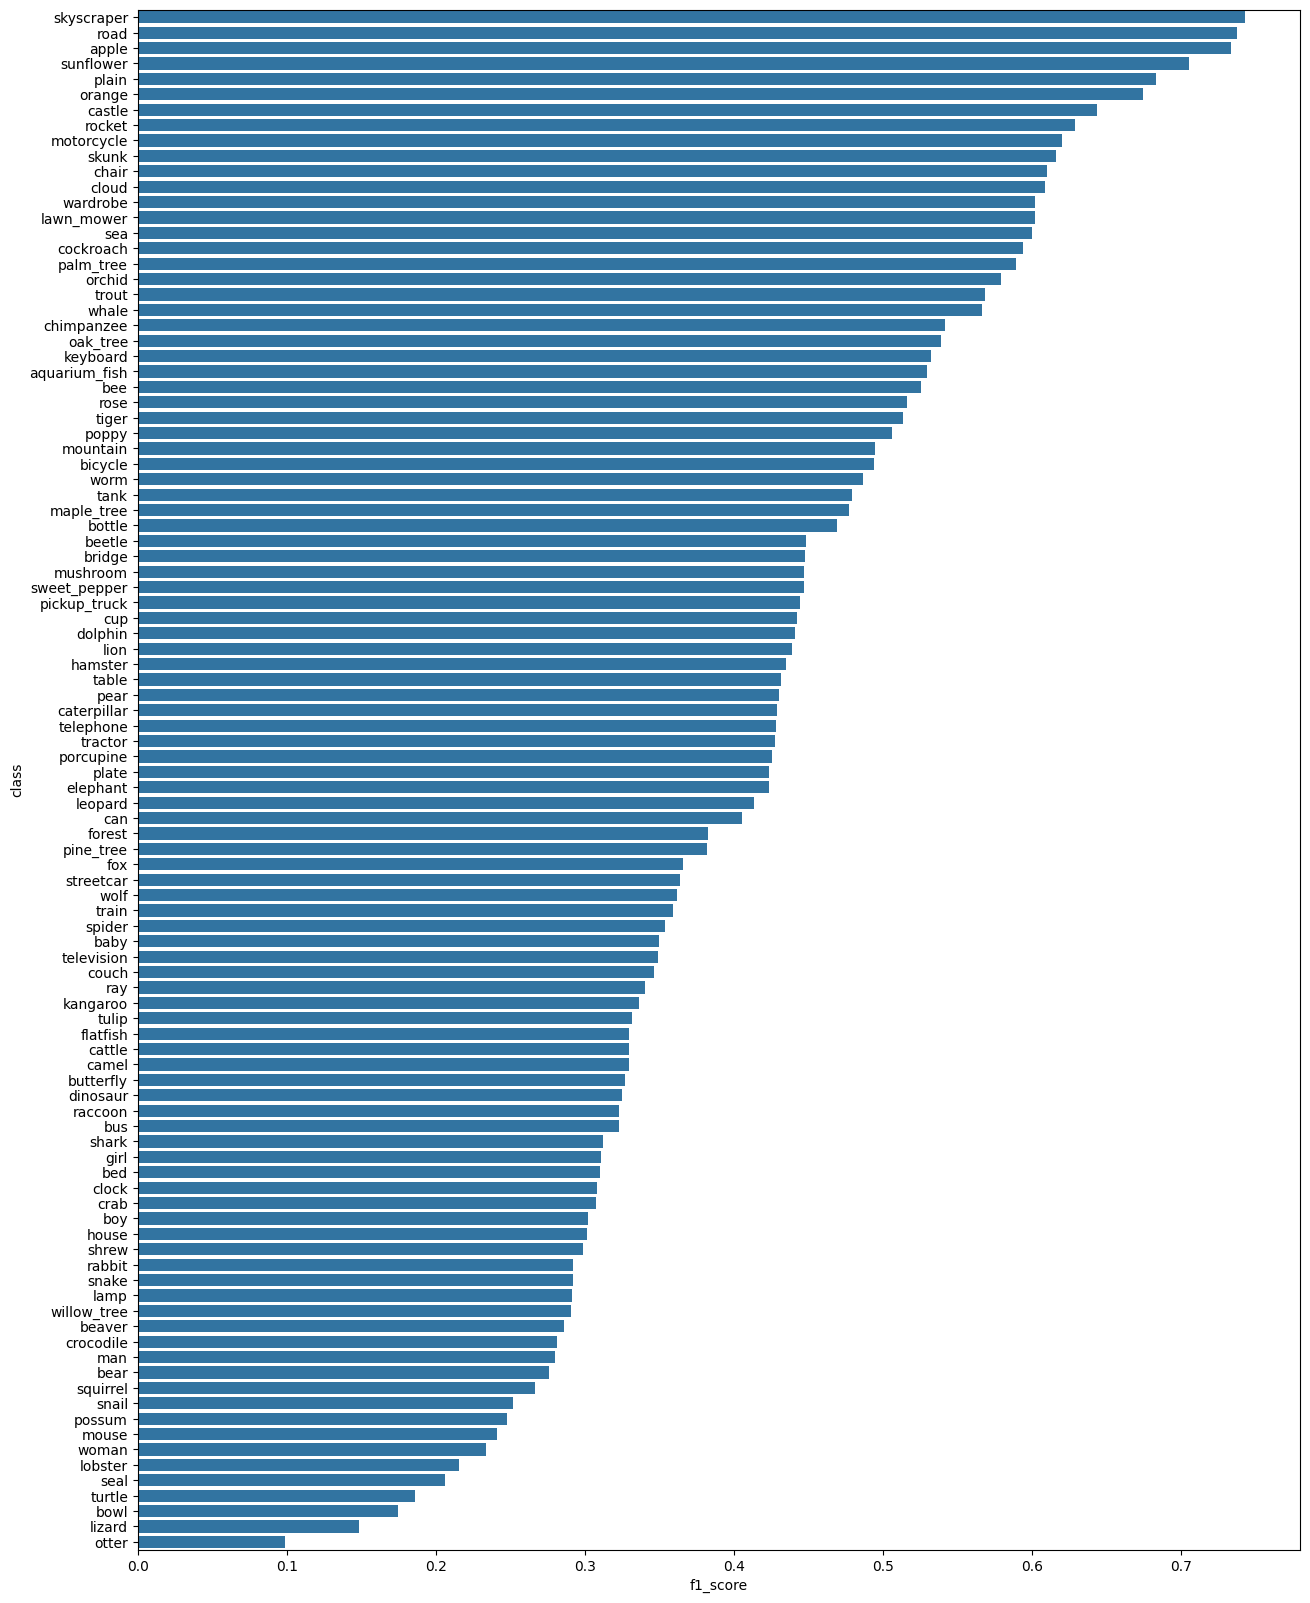

In [ ]:
plt.figure(figsize = (15, 20), dpi = 100)
sns.barplot(x = f1_df['f1_score'], y = f1_df['class'])

### 10.04 False Prediction

In [ ]:
false_pred = prediction_result[prediction_result['pred_check'] == False].sort_values('predict_score', ascending = False)[:100]
false_pred.head(10)

,label_num,label_name,predict_num,predict_name,predict_score,pred_check
30,20,chair,26,crab,1.000000,False
49,17,castle,76,skyscraper,0.999997,False
5138,61,plate,78,snake,0.999993,False
9312,91,trout,54,orchid,0.999988,False
6421,82,sunflower,60,plain,0.999979,False
7184,61,plate,22,clock,0.999971,False
5444,10,bowl,18,caterpillar,0.999960,False
8487,6,bee,62,poppy,0.999954,False
2055,39,keyboard,22,clock,0.999949,False
2315,15,camel,19,cattle,0.999948,False


<ipython-input-37-13fb0679bae3>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 4, i + 1)


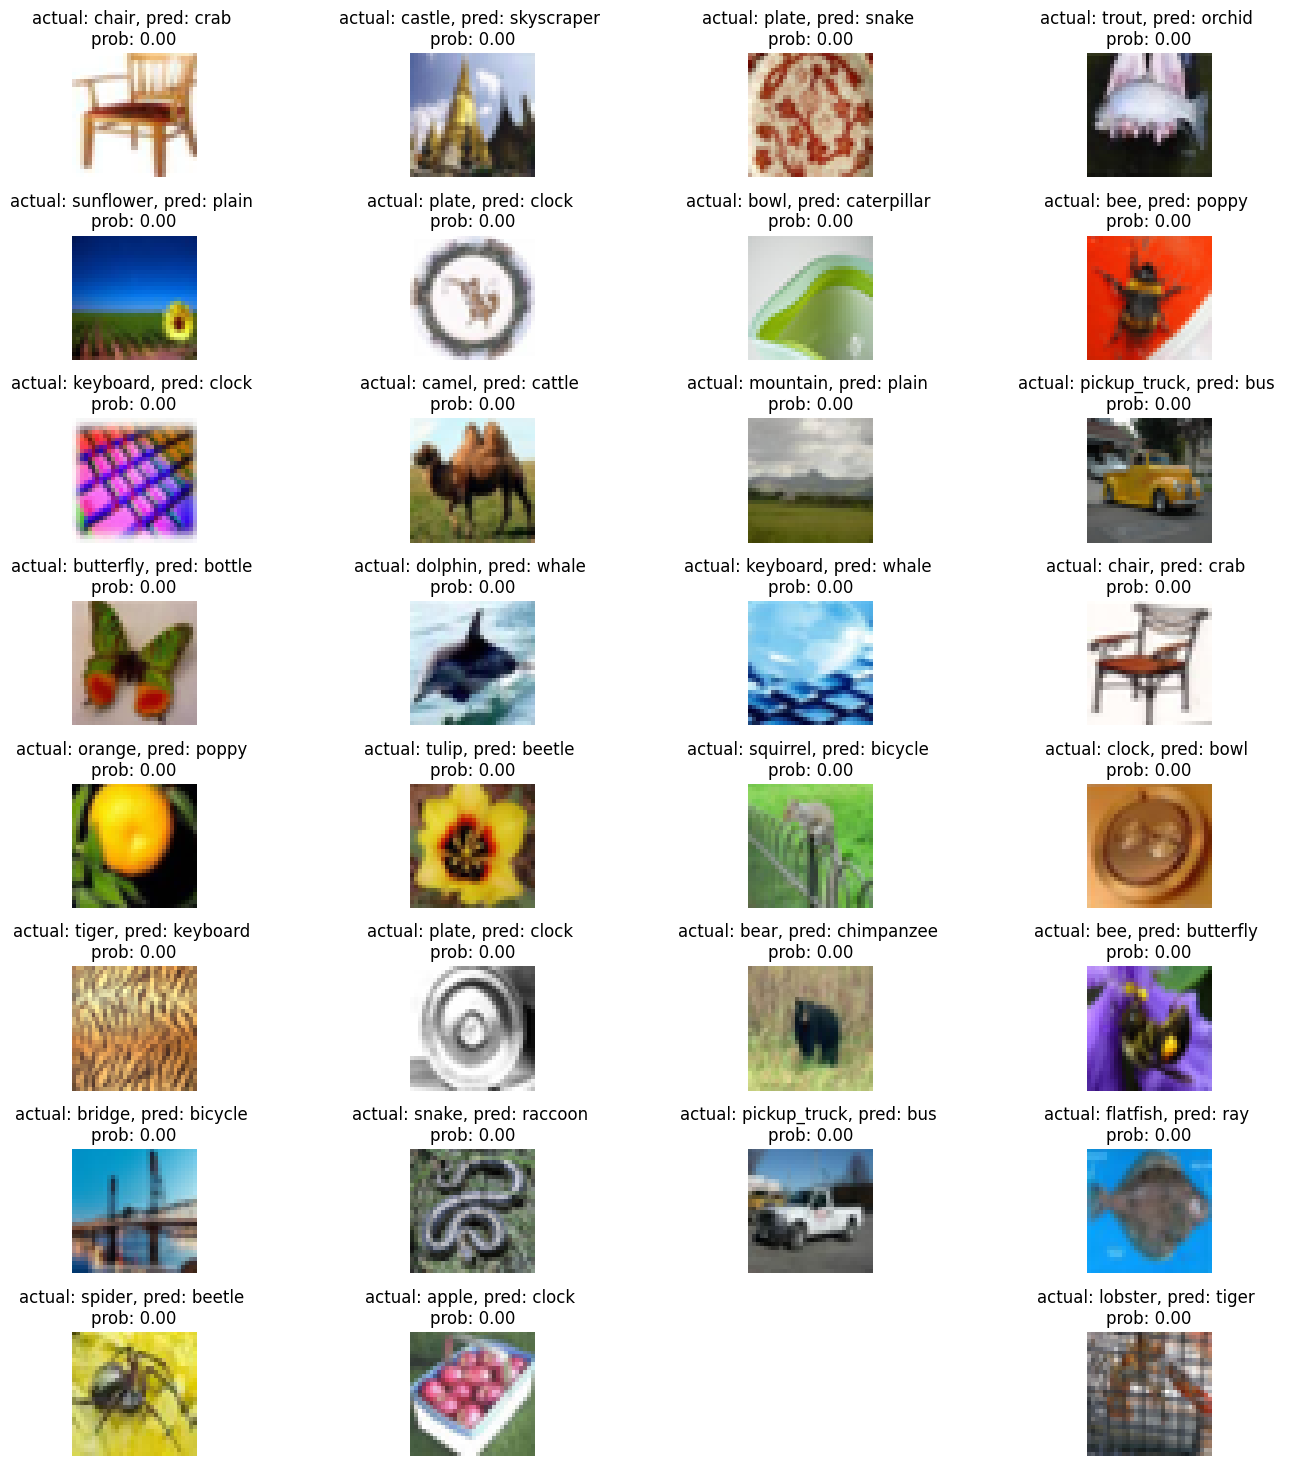

In [ ]:
plt.figure(figsize = (15, 15))
for i, row in enumerate(false_pred[:32].itertuples()):
  plt.subplot(8, 4, i + 1)
  data_plot = x_test[row[0]]
  _, _, label_name, _, predict_name, _, predict_score	 = row
  plt.imshow(data_plot)
  plt.title(f'actual: {label_name}, pred: {predict_name} \nprob: {predict_score	:.2f}')
  plt.tight_layout()
  plt.axis(False)

## 11 Saving Trained Model

In [ ]:
filename = str(dt.datetime.today().strftime('%Y%m%d_%H%M'))
save_dir = '/content/' + filename

model_json = model.to_json()
with open (save_dir + '.json', 'w') as json_file:
  json_file.write('/content/' + model_json)

model.save(save_dir + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 12 Live Test
run the cell and upload your local / downloaded image

In [ ]:
def prediction(file_dir):
  img = image.load_img(file_dir, target_size = (32, 32, 3))
  img = image.img_to_array(img)
  img = img / 255.0
  img = tf.expand_dims(img, axis = 0)

  prediction = model.predict([img])

  dense = prediction.reshape(-1).tolist()

  score = max(dense)
  index = dense.index(score)

  result = class_dict[index]
  name = result + '_' + str(round(score * 100, 2))

  title = 'Category : ' + result + ' | ' + 'Score : ' +  str(round(score * 100, 2)) + '%'
  plt.figure(figsize = (4, 4))
  plt.title(title)
  plt.imshow(img[0,:,:,:]) #'''

Saving camel.PNG to camel (2).PNG
1/1 [==============================] - 0s 40ms/step


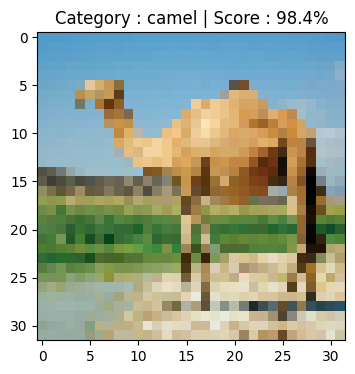

In [ ]:
from google.colab import files

uploaded = files.upload()

for key, value in uploaded.items():
  test_dir = '/content/' + key
  prediction(test_dir)